## Low pass filtering (Kurikawa _et al_ 2018)

$$
\frac{dr_{L,R}^{slow}}{dt} = \frac{r_{L,R}(t) - r_{L,R}^{slow}(t)}{\tau_{slow}}
$$

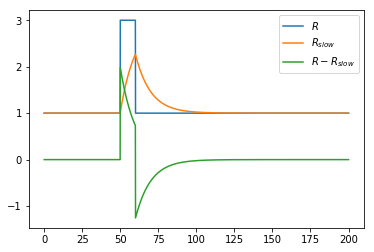

In [3]:
def dr_s(r_s, r, t, tau_s, dt):
    return (r - r_s)/tau_s*dt


t = np.linspace(0,200,2000)
r = np.ones_like(t)
r[500:600] = r[500:600] + 2
dt = 0.01
tau_s = 1
r_s = 1
R_S = []


for i in range(len(t)):
    r_s += dr_s(r_s, r[i], t[i], tau_s, dt)
    R_S.append(r_s)

plt.plot(t, r)
plt.plot(t, R_S)
plt.plot(t, r-R_S)
plt.legend(['$R$', '$R_{slow}$', '$R - R_{slow}$'])

So it turns out that that $ r_{L,R}(t) - r_{L,R}^{slow}(t) $ is non-zero (i.e. detects, high-pass filters) fast changes in the spiking rate faster that $tau_{slow}$, i.e. the less is tau, the less sensitive is the detector to fast changes

Text(0.5,0,'Trials')

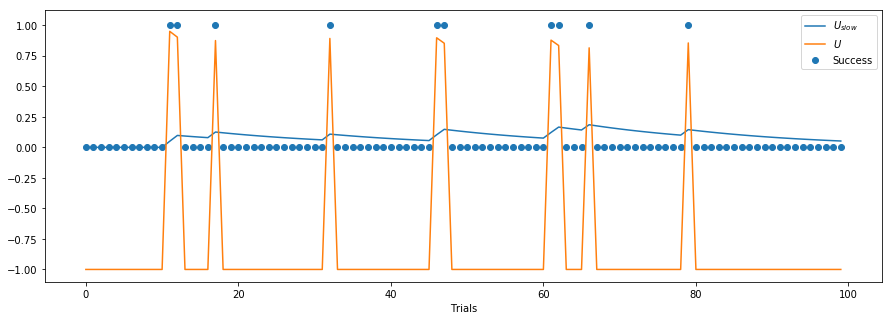

In [4]:
def get_U(U_slow, success):
    U_max = 1
    if success:
        U = U_max - U_slow
    else:
        U = -U_max
    return U

def get_U_slow(U_slow, success):
    U_max = 1
    gamma_u = 0.05
    if success:
        U_slow = (1-gamma_u)*U_slow + gamma_u*U_max
    else:
        U_slow = (1-gamma_u)*U_slow
    return U_slow

S = []
U_slow = 0
U_SLOW = []
U_FAST = []
for t in range(100):
    success = np.random.choice([0,1], p=[0.9, 0.1])
    U_slow = get_U_slow(U_slow, success)
    U = get_U(U_slow, success)
    U_SLOW.append(U_slow)
    U_FAST.append(U)
    S.append(success)

t = range(100)
plt.figure(figsize=(15,5))
plt.plot(t,U_SLOW)
plt.plot(t,U_FAST)
plt.scatter(t,S)
plt.legend(['$U_{slow}$', '$U$', 'Success'])
plt.xlabel('Trials')

        

## Let's create a reservoir network with two readout neurons:

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def get_gaussians(t,T):
    y1 = np.exp(-(t-T*0.15)**2/(2*15**2))
    y2 = np.exp(-(t-T*0.40)**2/(2*25**2))/3
    y3 = np.exp(-(t-T*0.80)**2/(2*15**2))/2
    return y1+y2+y3

class Neuron():
    def __init__(self, V0=-60, Ie=4, P_s0=0, num_synapses=4, neur_type=3):
        # neuron's electric constants:
        self.neur_type = neur_type # excitatory or inhibitory
        self.Ie = Ie   # external current, nA
        self.tau = 10 if neur_type==0 else 20 # ms
        self.Vth = -55 # threshold after which an AP is fired,   mV
        self.Vr = -70    # reset voltage (after an AP is fired), mV
        self.EL = -65    # mV
        self.Rm = 10     # MOhm
        self.Es = 100   # equilibrium potential for the synapse
        self.P_s = 0   # probability of channel conductance opening (set to 1 after an upstream neuron spikes)
        self.rm = 0.142857
        self.V_E = 0
        self.V_I = -80

        self.Vspike = 0
        self.AP = 0
        self.incoming_transmitter = 0
        self.I_tot = 0
        
        self.refractory_period = 1 # ms
        self.time_since_last_spike = 1
        
        # Intial conditions
        self.V = V0 # intial membrane voltage
        
        # initialize the axon's signalaling (what neurotransmitter this neuron can release):
        self.num_synapses = num_synapses
        self.synapses = []
        for i in range(self.num_synapses):
            self.synapses.append(self.Synapse())


    def step(self, dt):
        """
        MAKE ONE TIME STEP TO UPDATE THE NEURON'S PARAMETERS
        """
        for synapse in self.synapses:
            synapse.update(dt)
        
        # IAF model: dV/dt is membrane current.
        g_AMPA = np.sum([self.synapses[i].g_AMPA for i in range(self.num_synapses)])
        g_NMDA = np.sum([self.synapses[i].g_NMDA for i in range(self.num_synapses)])
        I_E = -g_AMPA*(self.V - self.V_E) - 0.1*g_NMDA*(self.V - self.V_E)
        g_GABA = np.sum([self.synapses[i].g_GABA for i in range(self.num_synapses)])
        I_I = -g_GABA*(self.V - self.V_I)
        dV = (-(self.V - self.EL)/self.tau + I_E + I_I + self.Ie)*dt
    
        self.time_since_last_spike += dt
        
        if self.AP==1:
            self.AP = 0
            self.V = self.Vr

        # if the threshold voltage is reached, fire and action potential:
        if self.V > self.Vth and self.AP==0 and self.time_since_last_spike >= self.refractory_period:
            self.V = self.Vspike
            self.AP = 1
            self.time_since_last_spike = 0
        
        if self.AP==0:
            self.V += dV
        
        return self.V
    
    class Synapse:
        def __init__(self):
            self.neur_type = []
            self.incoming_AP = 0
            # synaptic conductances:
            self.g_GABA = 0
            self.g_AMPA = 0
            self.g_NMDA = 0
            # tau-parameters
            self.tau_AMPA = 8
            self.tau_NMDA = 100
            self.tau_GABA = 8
            self.W = 0        # weight
            
        def update(self, dt):
            kronecker = 1 if self.incoming_AP == 1 else 0
            if self.neur_type == 0:
                self.g_AMPA += (-self.g_AMPA/self.tau_AMPA + kronecker * self.W)*dt
                self.g_NMDA += (-self.g_NMDA/self.tau_NMDA + kronecker * self.W)*dt
            elif self.neur_type == 1:
                self.g_GABA += (-self.g_GABA/self.tau_GABA + kronecker * self.W)*dt
            else:
                pass
#                 print('ERROR')
            self.incoming_AP = 0
            

class Network():
    def __init__(self):
        # DEFINE SIMULATION PARAMETERS:
        self.N = 5 # number neurons in the network
        self.M = 3 # number of synapses a neuron has (not all of them have to receive connections from upstream neurons)
        self.S = 0.1 # network's sparsity (how many synapses in the network receive no input from upstream neurons)
        self.dt = 0.01 # time step in milliseconds

        # create a list of neuron objects and populate it:
        self.neurons = []
        neur_types = np.random.randint(2, size=self.N)
        print(neur_types)
        for i in range(self.N):
            self.neurons.append(Neuron(Ie=1.5, num_synapses=self.M, neur_type=neur_types[i]))
        
        # Define network topology:   
        self.route = self.define_topology(self.N, self.M, self.S)         # Define the network's topology:
        
        # define weights and assign them to all synapses in all neurons:
#         self.route = self.route * np.random.rand(*self.route.shape)
        for presynaptic in range(self.N):
            for postsynaptic in range(self.N):
                target_synapse = np.nonzero(self.route[presynaptic, postsynaptic,:])[0].tolist()
                for i in target_synapse:
                    self.neurons[postsynaptic].synapses[i].W = self.route[presynaptic, postsynaptic, i]
                    self.neurons[postsynaptic].synapses[i].neur_type = self.neurons[presynaptic].neur_type
        
        # Change some default initialization parameters:
        for i in range(3,self.N):
            self.neurons[i].Ie = 0
            
        # Show network config and topology:
        print('NET PARAMETERS:\nNeurons:\t{}\nSynapses:\t{}\nSparsity:\t{}\ndt:\t\t{}\n'.format(
            self.N, self.M, self.S, self.dt))
        if self.N < 7:
            if self.N > 2:
                plt.figure(figsize=(15,5))
            for i in range(self.M):
                plt.subplot(1,self.M,i+1)
                plt.imshow(self.route[:,:,i])
                plt.ylabel('Signaling neurons')
                plt.xlabel('Receiving neurons')
                plt.title('Receiving synapse ' + str(i))
                plt.tight_layout()
        for n in range(self.N):
            print('{}\t{}\t{}\t{}\n'.format(
                ['excitatory' if self.neurons[n].neur_type==0 else 'inhibitory'],
                *[self.neurons[n].synapses[syn].neur_type for syn in range(self.M)])
                 )
        
    def define_topology(self, NumOfNeurons, numOfSynapses, sparsity=0.5):
        route = np.random.choice([0,1], p=[sparsity, 1-sparsity], size=(NumOfNeurons,NumOfNeurons,numOfSynapses))
        for i in range(NumOfNeurons):
            route[i,i,:] = 0
        a = np.array(np.arange(NumOfNeurons))
        for i in range(numOfSynapses):
            b = np.delete(a,i)
            route[b,:,i] = 0
        return route
    
    def step(self, dt):
        VV = np.zeros((self.N, ))
        for n in range(self.N):
            CN = self.neurons[n]
            VV[n] = CN.step(dt)
        # tell relevant synapses in relevant downstream neurons which upstream neurons have fired:
        for source in range(self.N):
            for target in range(self.N):
                target_synapses = np.nonzero(self.route[source, target,:])[0].tolist()
                for target_synapse in target_synapses:
                    if self.neurons[source].AP==1:
                        self.neurons[target].synapses[target_synapse].incoming_AP = 1
        return VV


[1 0 1 0 1]
NET PARAMETERS:
Neurons:	5
Synapses:	3
Sparsity:	0.1
dt:		0.01

['inhibitory']	[]	[]	1

['excitatory']	1	[]	1

['inhibitory']	1	0	[]

['excitatory']	1	0	1

['inhibitory']	1	0	1



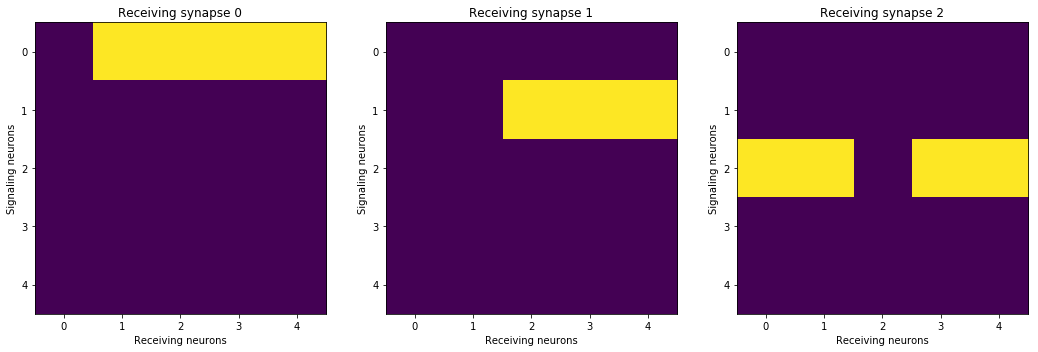

In [6]:
net = Network()

[1 3]
[0 2 4]


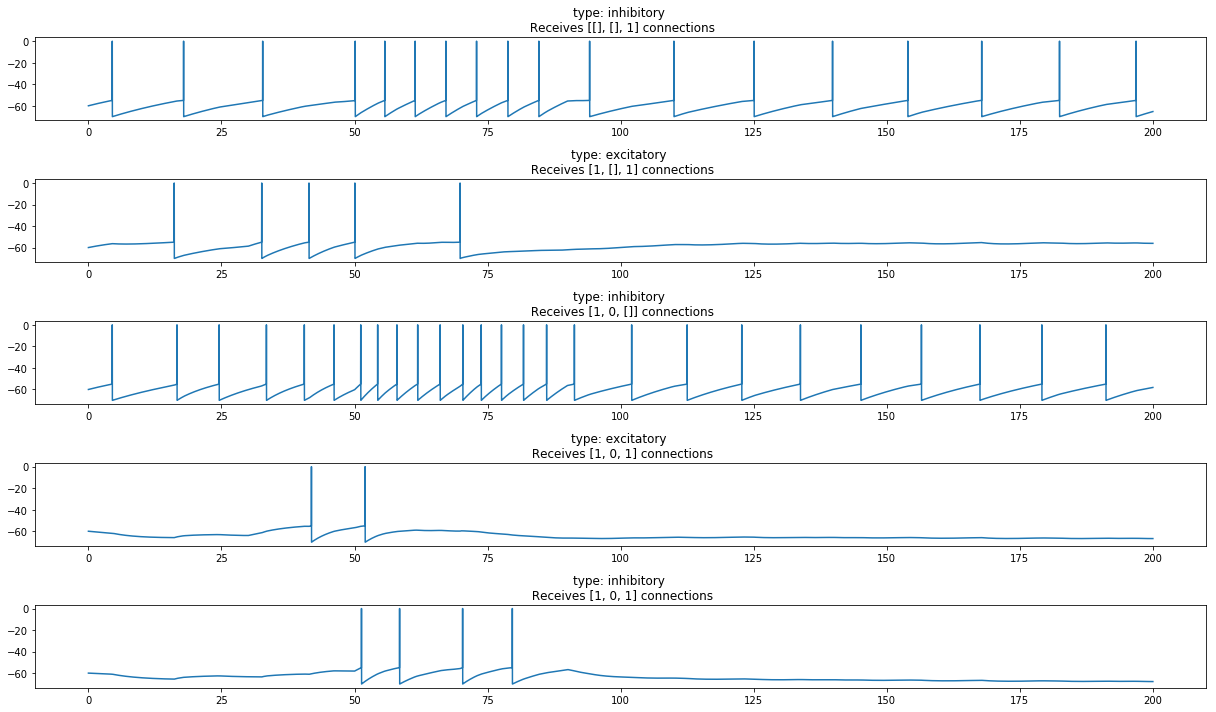

In [7]:
T = 200
dt = 0.02
timeline = np.arange(0, T, dt)
V = []

excit = np.array([net.neurons[i].neur_type for i in range(net.N)])
excit = np.where(excit==0)[0]
inhib = np.array([net.neurons[i].neur_type for i in range(net.N)])
inhib = np.where(inhib==1)[0]
print(excit)
print(inhib)
gGABA1, gAMPA1, gNMDA1, gGABA2, gAMPA2, gNMDA2 = [],[],[], [],[],[]
gGABA3, gAMPA3, gNMDA3, gGABA4, gAMPA4, gNMDA4 = [],[],[], [],[],[]
for t in timeline:
    v = net.step(dt)
    if t == 30:
        for j in excit:
            net.neurons[j].Ie += 1.2
    if t == 70:
        for j in excit:
            net.neurons[j].Ie -= 1.2

    if t == 50:
        for j in inhib:
            net.neurons[j].Ie += 2
    if t == 90:
        for j in inhib:
            net.neurons[j].Ie -= 2
    V.append(v)
    gGABA1.append(net.neurons[0].synapses[0].g_GABA)
    gAMPA1.append(net.neurons[0].synapses[0].g_AMPA)
    gNMDA1.append(net.neurons[0].synapses[0].g_NMDA)
    gGABA2.append(net.neurons[0].synapses[1].g_GABA)
    gAMPA2.append(net.neurons[0].synapses[1].g_AMPA)
    gNMDA2.append(net.neurons[0].synapses[1].g_NMDA)
    gGABA3.append(net.neurons[1].synapses[0].g_GABA)
    gAMPA3.append(net.neurons[1].synapses[0].g_AMPA)
    gNMDA3.append(net.neurons[1].synapses[0].g_NMDA)
    gGABA4.append(net.neurons[1].synapses[1].g_GABA)
    gAMPA4.append(net.neurons[1].synapses[1].g_AMPA)
    gNMDA4.append(net.neurons[1].synapses[1].g_NMDA)
V = np.vstack(V)
plt.figure(figsize=(17,10))
for i in range(V.shape[1]):
    plt.subplot(V.shape[1],1,i+1)
    plt.plot(timeline, V[:,i])
    string = 'type: {} \n Receives {} connections'.format(
        ['excitatory' if net.neurons[i].neur_type==0 else 'inhibitory'][0],
        [net.neurons[i].synapses[j].neur_type for j in range(net.neurons[i].num_synapses)])
    plt.title(string)
plt.tight_layout()

Text(0.5,1,'1')

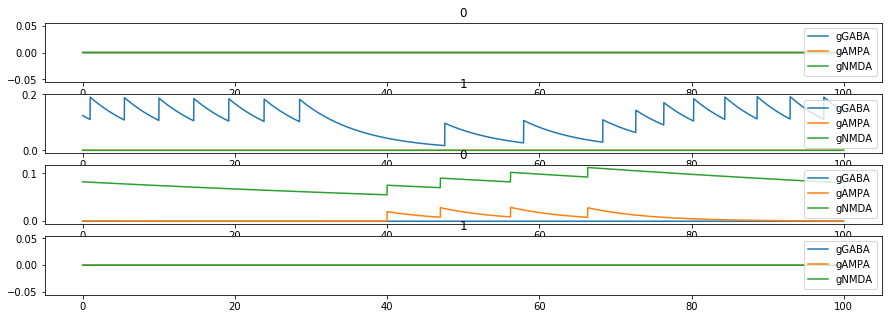

In [64]:
plt.figure(figsize=(15,5))
plt.subplot(4,1,1)
plt.plot(timeline, gGABA1)
plt.plot(timeline, gAMPA1)
plt.plot(timeline, gNMDA1)
plt.legend(['gGABA', 'gAMPA', 'gNMDA'])
plt.title(net.neurons[0].neur_type)
plt.subplot(4,1,2)
plt.plot(timeline, gGABA2)
plt.plot(timeline, gAMPA2)
plt.plot(timeline, gNMDA2)
plt.legend(['gGABA', 'gAMPA', 'gNMDA'])
plt.title(net.neurons[1].neur_type)

plt.subplot(4,1,3)
plt.plot(timeline, gGABA3)
plt.plot(timeline, gAMPA3)
plt.plot(timeline, gNMDA3)
plt.legend(['gGABA', 'gAMPA', 'gNMDA'])
plt.title(net.neurons[0].neur_type)
plt.subplot(4,1,4)
plt.plot(timeline, gGABA4)
plt.plot(timeline, gAMPA4)
plt.plot(timeline, gNMDA4)
plt.legend(['gGABA', 'gAMPA', 'gNMDA'])
plt.title(net.neurons[1].neur_type)